In [30]:
import numpy as np, pandas as pd, celerite, emcee as mc, corner
from celerite import terms
from glob import glob
from matplotlib import pyplot as plt
from scipy.optimize import minimize

%matplotlib inline

In [2]:
#Slow bit of code that parses out source names
files = glob('test_data/*')
source_names = []
for file in files:
    if file[10:15] == 'WISE ':
        wise_id = file[15:34]
        source_names.append(wise_id)
unique_names = np.unique(source_names)
unique_names

array(['J000108.82+585847.4', 'J215803.09+485330.7'], dtype='<U19')

In [6]:
def get_lightcurve(name, clean=True):
    
    """
    From a WISE source name, creates a lightcurve stored in a pandas DataFrame. Lightcurve
    will be cleaned
    
    Parameters
    ----------
    name : str
        WISE source name, in the format Jhhmmss.ss+/-ddmmss.s
    clean : bool
        If True, cleans the data using quality flags in the individual csv files used
        to create the lightcurve. Default True.
        
    Returns
    -------
    df : `~pandas.DataFrame`
    
    """
    
    dfs = []
    #Get relevant data files
    all_csvs = glob('test_data/*{}*.csv'.format(name))
    for csv in all_csvs:
        #read data
        data = pd.read_csv(csv)
        if clean:
            #kinda hacky cleaning
            ok = (
                (data['ph_qual'].str[0] == 'A') &
                (data['nb'] == 1) &
                ((data['cc_flags'].astype(object).str[0:2].astype(str) == '00')|(data['cc_flags'].astype(object) == 0)) &
                (data['w1rchi2'] < 5)
                 )
            if 'qual_frame' in data.columns:
                ok = ok & (data['qual_frame'] > 8)

            dfs.append(data[ok])
        else:
            dfs.append(data)
            
    #final LC concatenated and sorted on MJD
    df = pd.concat(dfs)
    df.sort_values('mjd',inplace=True)
    
    return df

J000108.82+585847.4


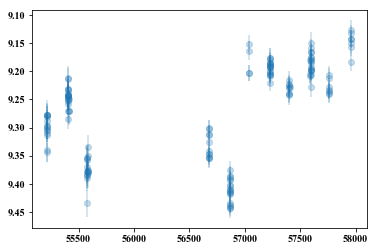

In [41]:
#Try accessing and concatenating lightcurves
for name in unique_names[:1]:
    print(name)
    
    df = get_lightcurve(name)
    
    plt.errorbar(df['mjd'], df['w1mpro'], yerr=df['w1sigmpro'],
                 marker='o', linestyle='none', alpha=0.25)
plt.gca().invert_yaxis()

In [42]:
mjd,W1,W1err = df['mjd'].values, df['w1mpro'].values, df['w1sigmpro'].values

### For stochastic variability, a DRW-type kernel might be suitable. We'll also try a periodic one later

### $k(\Delta t) = \sigma^2 e^{-\Delta t/\tau}$

In [8]:
#A DRW Kernel. Just a normal RealTerm object, reconfigured to look like a DRW kernel

class CustomTerm(terms.RealTerm):
    parameter_names = ("log_sigma", "log_tau")

    def get_real_coefficients(self, params):
        log_sigma, log_tau = params
        sigma = np.exp(log_sigma)
        return (
            sigma**2.0 , 1.0/np.exp(log_tau),
        )

In [43]:
#bounds? Keep it real basic for now. Probably should be defined by the data when we do 
#this for real
bounds = dict(log_sigma=(-15, 15), log_tau=(-15, 15))

#Define the kernel. Initial guess is going to be ~1 mag for sigma, ~500 days for tau
kernel = CustomTerm(log_sigma=np.log(1), log_tau=np.log(500), bounds=bounds)

#make a GP object
gp = celerite.GP(kernel, mean=np.mean(W1), fit_mean = True)
 #computes the initial covariance matrix
gp.compute(mjd, W1err)
print("Initial log-likelihood: {0}".format(gp.log_likelihood(W1)))

Initial log-likelihood: 303.47135530808714


In [44]:
# Define a cost function
def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

def grad_neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.grad_log_likelihood(y)[1]


# Fit for the maximum likelihood parameters
initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()

#The solver needs autograd.numpy for reasons?
import autograd.numpy as np
soln = minimize(neg_log_like, initial_params, jac=grad_neg_log_like,
                method="L-BFGS-B", bounds=bounds, args=(W1, gp))
import numpy as np

gp.set_parameter_vector(soln.x)
print("Final log-likelihood: {0}".format(-soln.fun))


# Make the maximum likelihood prediction
t = np.linspace(np.min(mjd), np.max(mjd), 500)
mu, var = gp.predict(W1, t, return_var=True)
std = np.sqrt(var)

Final log-likelihood: 351.6737631629777


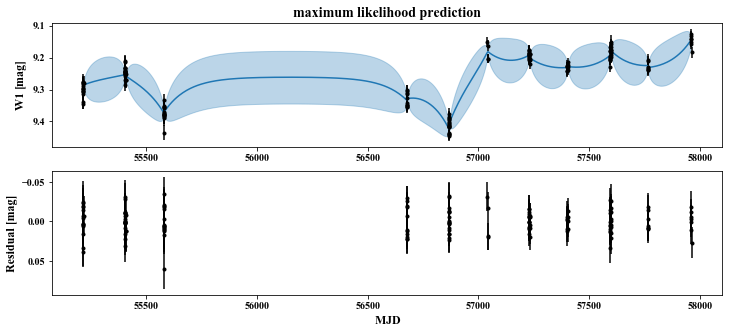

In [45]:
# Plot the data, and the DRW-subtracted data as well
color = "C0"
fig,ax = plt.subplots(2, figsize = (12,5))
ax[0].errorbar(mjd, W1, yerr=W1err, fmt=".k", capsize=0)
ax[0].plot(t, mu, color=color)
ax[0].fill_between(t, mu+std, mu-std, color=color, alpha=0.3, edgecolor="none")
ax[0].set_ylabel(r"$W1$ [mag]")
ax[0].invert_yaxis()

mod,mod_var = gp.predict(W1, mjd, return_var = True)
resid = W1 - mod
resid_err = np.sqrt(W1err**2.0 + mod_var)
ax[1].errorbar(mjd, resid, yerr=resid_err, fmt=".k", capsize=0)
ax[1].set_ylabel(r"Residual [mag]")
ax[1].invert_yaxis()
ax[1].set_xlabel(r"$MJD$")
ax[0].set_title("maximum likelihood prediction");

In [46]:
# Zooming in on individual visits:
dt_tol = 100
visits = []
visit = np.array([[mjd[0],W1[0],W1err[0]]])
for i in range(1,len(mjd)):
    dif = mjd[i] - mjd[i-1]
    if dif <= dt_tol:
        visit = np.append(visit,[[mjd[i],W1[i],W1err[i]]],axis=0)
    else:
        visits.append(visit)
        visit = np.array([[mjd[i],W1[i],W1err[i]]])
visits.append(visit)
visits = np.array(visits)

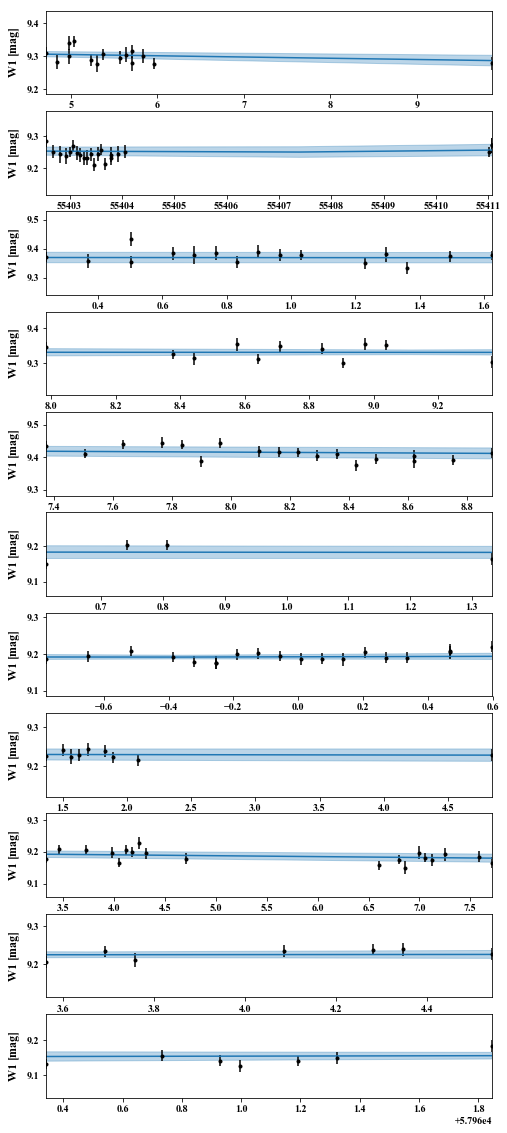

In [47]:
fig,axes = plt.subplots(len(visits), figsize = (8,20))

for ax,visit in zip(axes,visits):
    ms = visit[:,0]
    ws = visit[:,1]
    es = visit[:,2]
    
    ax.errorbar(ms, ws, yerr=es, fmt=".k", capsize=0)
    ax.plot(t, mu, color=color)
    ax.fill_between(t, mu+std, mu-std, color=color, alpha=0.3, edgecolor="none")
    ax.set_ylabel(r"$W1$ [mag]")
    ax.invert_yaxis()
    ax.set_xlim(min(ms),max(ms))
    ax.set_ylim(0.99*min(ws),1.01*max(ws))

In [48]:
#Now let's explore possible realizations with emcee.

#Need a log probability
def log_probability(params):
    gp.set_parameter_vector(params)
    lp = gp.log_prior()
    if not np.isfinite(lp):
        return -np.inf
    return gp.log_likelihood(W1) + lp

In [49]:
#Take the maximum likelihood as the initial guess
initial = np.array(soln.x)
ndim, nwalkers = len(initial), 32
sampler = mc.EnsembleSampler(nwalkers, ndim, log_probability)

print("Running burn-in for 500 steps...")
#A tiny little ball around that solution
p0 = initial + 1e-8 * np.random.randn(nwalkers, ndim)
p0, lp, _ = sampler.run_mcmc(p0, 500)

print("Running for real for 3000 steps...")
sampler.reset()
sampler.run_mcmc(p0, 3000);

Running burn-in for 500 steps...
Running for real for 3000 steps...


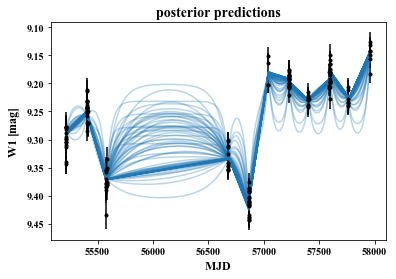

In [50]:
#Let's take 100 samples and see how it looks

# Plot the data.
plt.errorbar(mjd, W1, yerr=W1err, fmt=".k", capsize=0)

# Plot 100 posterior samples.
samples = sampler.flatchain
for s in samples[np.random.randint(len(samples), size=100)]:
    gp.set_parameter_vector(s)
    mu = gp.predict(W1, t, return_cov=False)
    plt.plot(t, mu, color=color, alpha=0.3)

plt.ylabel(r"$W1$ [mag]")
plt.xlabel(r"$MJD$")
plt.gca().invert_yaxis()
plt.title("posterior predictions");

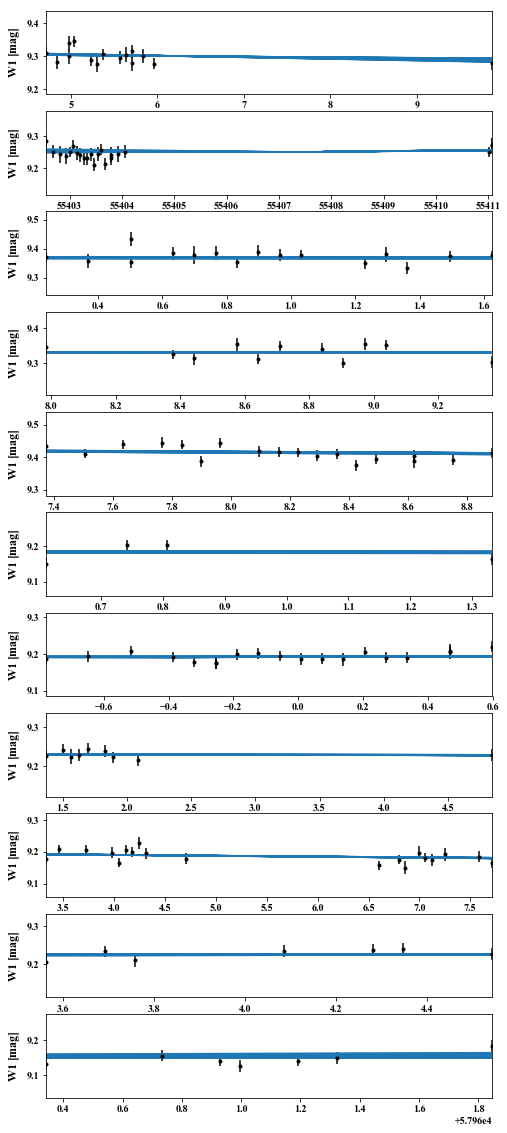

In [51]:
#And individual visits:

fig,axes = plt.subplots(len(visits), figsize = (8,20))

for ax,visit in zip(axes,visits):
    ms = visit[:,0]
    ws = visit[:,1]
    es = visit[:,2]
    
    ax.errorbar(ms, ws, yerr=es, fmt=".k", capsize=0)
    ax.set_ylabel(r"$W1$ [mag]")
    ax.invert_yaxis()
    ax.set_xlim(min(ms),max(ms))
    ax.set_ylim(0.99*min(ws),1.01*max(ws))
    
for s in samples[np.random.randint(len(samples), size=100)]:
    gp.set_parameter_vector(s)
    mu = gp.predict(W1, t, return_cov=False)
    for ax,visit in zip(axes,visits):
        ax.plot(t, mu, color=color)

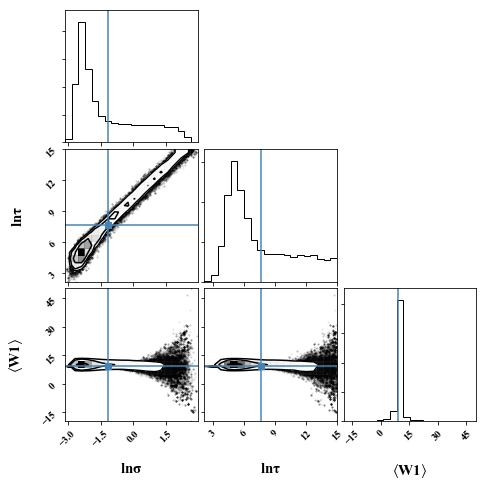

In [52]:
log_sigma_true = np.mean(samples[:,0])
log_tau_true = np.mean(samples[:,1])
mean_true = np.mean(samples[:,2])

fig = corner.corner(samples, truths=[log_sigma_true,log_tau_true,mean_true],
              labels=[r"$ln\sigma$", r"$ln\tau$", r"$\langle W1 \rangle$"],
              label_kwargs = {'fontsize':15});
fig.set_size_inches(7,7)

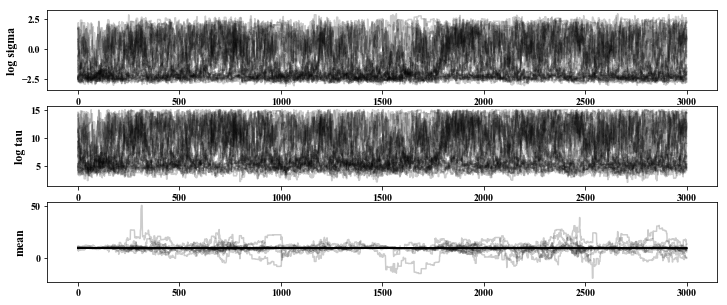

In [53]:
fig,ax = plt.subplots(3, figsize=(12,5))
for walker in sampler.chain:
    ax[0].plot(walker[:,0],c='k',alpha=0.2)
    ax[1].plot(walker[:,1],c='k',alpha=0.2)
    ax[2].plot(walker[:,2],c='k',alpha=0.2)
ax[0].set_ylabel('log sigma')
ax[1].set_ylabel('log tau')
ax[2].set_ylabel('mean');

In [54]:
print(np.exp(log_sigma_true),np.exp(log_tau_true),mean_true)

0.31099647221987253 2097.846167194618 9.210426466265039


In [55]:
#So a DRW is actually pretty bad at describing these data. There's plenty of variability
#at multiple timescales, so a 'decay' type model might be having a hard time. Regardless,
#let's run this in one cell, so we can see how long it takes for future reference.

In [58]:
%%time

bounds = dict(log_sigma=(-15, 15), log_tau=(-15, 15))
#Define the kernel. Initial guess is going to be ~1 mag for sigma, ~500 days for tau
kernel = CustomTerm(log_sigma=np.log(1), log_tau=np.log(500), bounds=bounds)

#make a GP object
gp = celerite.GP(kernel, mean=np.mean(W1), fit_mean = True)

#compute the initial covariance matrix
gp.compute(mjd, W1err)

# don't need to run this, as it can take arbitrary data/gp objects
"""def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

def grad_neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.grad_log_likelihood(y)[1]"""

# Fit for the maximum likelihood parameters
initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()

#The solver needs autograd.numpy for reasons?
import autograd.numpy as np
soln = minimize(neg_log_like, initial_params, jac=grad_neg_log_like,
                method="L-BFGS-B", bounds=bounds, args=(W1, gp))
import numpy as np

gp.set_parameter_vector(soln.x)

#Need a log probability
def log_probability(params):
    gp.set_parameter_vector(params)
    lp = gp.log_prior()
    if not np.isfinite(lp):
        return -np.inf
    return gp.log_likelihood(W1) + lp

#Take the maximum likelihood as the initial guess
initial = np.array(soln.x)
ndim, nwalkers = len(initial), 32
sampler = mc.EnsembleSampler(nwalkers, ndim, log_probability)

print("Running burn-in for 500 steps...")
#A tiny little ball around that solution
p0 = initial + 1e-8 * np.random.randn(nwalkers, ndim)
p0, lp, _ = sampler.run_mcmc(p0, 500)

print("Running for real for 3000 steps...")
sampler.reset()
sampler.run_mcmc(p0, 3000);

log_sigma_true = np.mean(samples[:,0])
log_tau_true = np.mean(samples[:,1])
mean_true = np.mean(samples[:,2])

print(np.exp(log_sigma_true),np.exp(log_tau_true))

Running burn-in for 500 steps...
Running for real for 3000 steps...
0.31099647221987253 2097.846167194618
CPU times: user 19.2 s, sys: 181 ms, total: 19.4 s
Wall time: 19.6 s
